<center><h1><b>Proyecto de Curso Aprendizaje Automático</b></h1>
<h2><b>Escuela de Posgrado PUCP</b></h2>
<h2><b>Maestría en Informática</b></h2></center>

**<h2>Importación de Librerías</h2>**


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn import preprocessing
from sklearn import naive_bayes
from sklearn import svm
from sklearn import pipeline
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
import numpy as np
matplotlib.rcParams['figure.dpi'] = 100

**<h2>Lectura de la data</h2>**

El conjunto de datos consta de los niveles de expresión de 77 proteínas que produjeron señales detectables en la parte nuclear del córtex (características continuas). Se tienen 38 ratones  sanos  y  34  ratones trisómicos  organizados en ocho clases (cada uno conformado por entre  7  y  10  ratones).  Por cada ratón se  han  tomado 15  muestras, por  ende, se tendrán 570 y  510 muestras para los ratones sanos y trisómicos respectivamente.

In [6]:
dataset = pd.read_excel("Data_Cortex_Nuclear.xls")

In [7]:
print(f"Las dimensiones del dataset son {dataset.shape}")
dataset.head()

Las dimensiones del dataset son (1080, 82)


,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


**<h2>Preprocesamiento</h2>**

La estrategia que se utilizará para el manejo de datos faltantes será la imputación de los mismos por el estadístico media para cada clase.

**<h3>Imputación de datos faltantes</h3>**

In [8]:
preprocDataset = dataset.copy()

#Obtenemos la media de cada clase.
median_of_classes = preprocDataset.groupby("class").mean()

#Obtenemos la lista de clases para realizar la iteración sobre ellas.
classes = preprocDataset["class"].unique()

for className in classes:
  dataframeOfClass = preprocDataset.loc[preprocDataset["class"] == className,:]

  #Reemplazamos los nulos con la media de cada clase.
  preprocDataset.loc[preprocDataset["class"] == className,:] = dataframeOfClass.fillna(median_of_classes.loc[className])
  
#No se eliminan registros duplicados porque no los hay.

#Se elimina información redundante "Genotype", "Treatment", "Behavior" que ya están combinadas en la columna clase.
preprocDataset.drop(["Genotype", "Treatment", "Behavior"], axis=1, inplace=True)

#Se separan las versiones y números de ratones en otras variables
MouseNumber = preprocDataset.MouseID.apply(lambda x: x.split('_')[0])
MouseVersion = preprocDataset.MouseID.apply(lambda x: x.split('_')[1])

#Se elimina información irrelevante para la tarea de clasificación multiclase
preprocDataset.drop("MouseID", axis=1, inplace=True)

In [9]:
preprocDataset.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,class
0,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.122652,0.132539,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,c-CS-m
1,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.116682,0.132539,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,c-CS-m
2,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.118508,0.132539,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,c-CS-m
3,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.132781,0.132539,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,c-CS-m
4,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.129954,0.132539,0.104784,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,c-CS-m


**<h2> Separación y etiquetado de datos</h2>**

In [10]:
x = preprocDataset.drop("class",axis=1)
y = preprocDataset["class"]

**<h2>Codificación de la etiqueta</h2>**

In [11]:
from sklearn.preprocessing import LabelEncoder

y_coded = LabelEncoder().fit_transform(y)

**<h3>Análisis de separabilidad de la data</h3>**

In [14]:
from sklearn.manifold import TSNE
x_embedded = TSNE(n_components=2, n_jobs=-1).fit_transform(x)

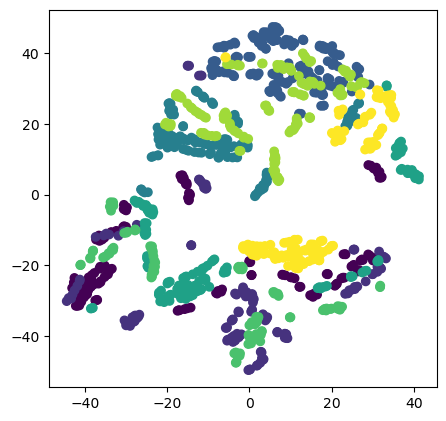

In [15]:
plt.figure(figsize=(5, 5))
plt.scatter(x_embedded[:,0], x_embedded[:,1], c=y_coded)
plt.show()

Se observa del gráfico t-SNE que las clases de los datos están medianamente separados, por tanto, se espera que los modelos a entrenar tengan una precisión razonablemente alta.

**<h2>Separación de conjunto de entrenamiento de conjunto de pruebas</h2>**

In [16]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y_coded, train_size=0.8,random_state=0,stratify=y_coded)

## Escalamiento de data

Se utilizará la clase ***pipeline*** para realizar el escalamiento sólo en la data de entrenamiento correspondiente a la validación ***k-fold***, por lo que el escalamiento se realizará previo al entrenamiento de cada modelo.

# Algoritmos a entrenar

## Random Forest

In [25]:
#Definicion de escalamiento, modelo y pipeline a utilizar para el entrenamiento
rfc_scaler = preprocessing.StandardScaler()
rfc_model = RandomForestClassifier(class_weight="balanced",random_state=0)
rfc_pipeline = pipeline.Pipeline([("scaler", rfc_scaler), ("rfc", rfc_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
grid_rfc = {"rfc__n_estimators": range(1,400,10), 
            "rfc__max_depth": range(1,31,3),
            "rfc__min_samples_split": range(2, 40, 1),
            "rfc__min_samples_leaf": range(1, 20, 1)}

In [26]:
#Busqueda aleatoria
r_search_rfc =model_selection.RandomizedSearchCV(rfc_pipeline, grid_rfc, n_iter=40, n_jobs=-1,cv=8, random_state=0)
r_search_rfc.fit(x_train, y_train)

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('rfc',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=0))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'rfc__max_depth': range(1, 31, 3),
                                        'rfc__min_samples_leaf': range(1, 20),
                                        'rfc__min_samples_split': range(2, 40),
                                        'rfc__n_estimators': range(1, 400, 10)},
                   random_state=0)

In [27]:
best_rfc_pipeline = r_search_rfc.best_estimator_

train_score = best_rfc_pipeline.score(x_train, y_train)
test_score = best_rfc_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo RF es: {train_score}.")
print(f"La exactitud de prueba para el modelo RF es: {test_score}.")

La exactitud de entrenamiento para el modelo RF es: 1.0.
La exactitud de prueba para el modelo RF es: 1.0.


## Support Vector Machine

In [21]:
#Definicion de escalamiento, modelo y pipeline a utilizar para el entrenamiento
svm_scaler = preprocessing.StandardScaler()
svm_model = svm.SVC(kernel="rbf",class_weight="balanced",random_state=0)
svm_pipeline = pipeline.Pipeline([("scaler", svm_scaler), ("model", svm_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
gamma = np.logspace(-4, 2, num=20)
C = np.logspace(-4, 2, num=20)

grid_svm = {"model__gamma":gamma, "model__C":C}

In [22]:
#Busqueda aleatoria
r_search =model_selection.RandomizedSearchCV(svm_pipeline, grid_svm, n_iter=40,n_jobs=-1,cv=8, random_state=0)
r_search.fit(x_train, y_train)

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              SVC(class_weight='balanced',
                                                  random_state=0))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'model__C': array([1.00000000e-04, 2.06913808e-04, 4.28133240e-04, 8.85866790e-04,
       1.83298071e-03, 3.79269019e-03, 7.84759970e-03, 1.62377674e-02,
       3.35981829e-02, 6.95192796e-02, 1.43844...
       1.12883789e+01, 2.33572147e+01, 4.83293024e+01, 1.00000000e+02]),
                                        'model__gamma': array([1.00000000e-04, 2.06913808e-04, 4.28133240e-04, 8.85866790e-04,
       1.83298071e-03, 3.79269019e-03, 7.84759970e-03, 1.62377674e-02,
       3.35981829e-02, 6.95192796e-02, 1.43844989e-01, 2.97635144e-01,
       6.15848211e-01, 1.27427499e+00, 2.63665090e+00, 5.45559478e+00,
  

In [34]:
best_svm_pipeline = r_search.best_estimator_

#Chequear si el scaler se devuelve ajustado con la data de entrenamiento y si no se vuelve a ajustar cuando se le llama
#a score del pipeline
train_score = best_svm_pipeline.score(x_train, y_train)
test_score = best_svm_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo SVM con kernel RBF es: {train_score}.")
print(f"La exactitud de prueba para el modelo SVM con kernel RBF es: {test_score}.")

La exactitud de entrenamiento para el modelo SVM con kernel RBF es: 1.0.
La exactitud de prueba para el modelo SVM con kernel RBF es: 0.9907407407407407.


## Redes neuronales

- Escalamiento para regresión logística:

Debido a que la regresión logística trabaja con gradientes, se utiliza un estandarización

In [12]:
scaler = preprocessing.StandardScaler()
X_reglog = scaler.fit_transform(X[:])

In [13]:
X_reglog

array([[ 0.31364212,  0.51863341,  2.25324847, ..., -1.38279767,
        -1.53255733,  1.06590091],
       [ 0.35772124,  0.28722466,  1.87986806, ..., -1.29430291,
        -1.47394033,  1.28029118],
       [ 0.335893  ,  0.45117128,  2.012513  , ..., -1.34081199,
        -1.54763633,  1.85703831],
       ...,
       [-0.7908041 , -0.88270048, -1.72415432, ...,  1.2190181 ,
         3.00451359,  0.29352469],
       [-0.82075932, -0.81217872, -1.52420521, ...,  1.80997477,
         3.20716089,  0.2089962 ],
       [-0.49384406, -0.62043914, -1.26878897, ...,  1.85480549,
         3.20565882,  0.10478825]])

- Escalamiento para LightGBM

- Escalamiento para RandomForest

- Escalamiento para k-Nearest Neighbors (KNN)

- Escalamiento para Fedd-forward Neural Network

- Escalamiento para Naive Bayes

In [ ]:
# Aqui se realizará Regresión logística